# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2742],
         [ 0.3692]]),
 tensor([[ 1.0000e+00, -2.7416e-01,  3.7581e-02, -3.4344e-03,  2.3539e-04,
          -1.2907e-05,  5.8974e-07, -2.3097e-08,  7.9154e-10, -2.4112e-11,
           6.6104e-13, -1.6475e-14,  3.7640e-16, -7.9379e-18,  1.5545e-19,
          -2.8411e-21,  4.8682e-23, -7.8508e-25,  1.1958e-26, -1.7254e-28],
         [ 1.0000e+00,  3.6918e-01,  6.8147e-02,  8.3862e-03,  7.7401e-04,
           5.7150e-05,  3.5164e-06,  1.8546e-07,  8.5584e-09,  3.5107e-10,
           1.2961e-11,  4.3499e-13,  1.3382e-14,  3.8004e-16,  1.0022e-17,
           2.4665e-19,  5.6913e-21,  1.2359e-22,  2.5349e-24,  4.9255e-26]]),
 tensor([4.3482, 5.2393]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.0091734  1.2166717 -3.419578   5.560551 ]]


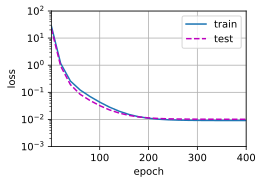

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.9958234 4.4569454]]


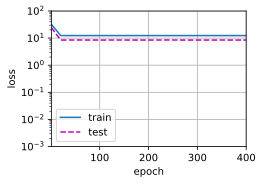

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9994216e+00  1.2866091e+00 -3.3809533e+00  5.1446929e+00
  -9.7943448e-02  1.2635678e+00  2.8201175e-01  1.7581673e-01
   2.2567120e-01  1.6265943e-03 -6.3553685e-03 -6.6786170e-02
   1.2412853e-02 -3.8822725e-02 -1.1766330e-01  7.8078448e-03
  -1.7254760e-02 -9.7340353e-02 -9.4486885e-02  2.2234076e-01]]


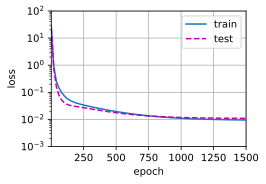

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)